In [1]:
# -*- coding: utf-8 -*-

# Universite Jean Monnet
# Laboratoire Hubert Curien
# Saint-Etienne

# Nathalie Bochard

# PLL-based TRNG - sampled period reconstruction
#

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path

## #########################################
## functions definition
## #########################################


def read_dff(filename, KM, KD):
    ###############################
    """Read dff bits from the raw file. Return a matrix of shape (n_cycles, KD)"""
    bytes_data = np.fromfile(filename, dtype="uint8")  # read bytes
    bits_data = np.unpackbits(bytes_data, axis=None, count=None, bitorder="little")  # unpack to bits
    bits_data = bits_data.reshape((-1, 32))[:, ::-1].ravel()  # reverse bits order in blocks of 32
    bits_data = np.resize(bits_data, (len(bits_data) // KD, KD))  # reshape to cycles
    return bits_data


def get_rng_from_dff(filename, data, KM, KD):
    #############################################
    """compute rng data from dff and record it to a file, nist compatible"""
    # counter of ones
    nb_ones = np.sum(data, 1)
    # sum inside Tq period
    # lsb
    rng = nb_ones % 2

    fileoutname = filename[:-4] + "_rng_nist_1bit.bin"
    rng = np.array(rng, dtype="uint8")

    # 1.000.000 bits are needed to pass NIST tests
    while len(rng) < 1000000:
        rng = np.concatenate([rng, rng])[:1000000]

    rng.tofile(fileoutname)

# Data

💡 To reproduce Fig 10 and Fig 11 use files `data/Regular/S6v11_2/B_1/acq_20230405133036_km464_kd475_dff.bin` and `data/Regular/S6v11_2/C_1/acq_20230405135452_km476_kd495_dff.bin`.

In [2]:
## #########################################
## variables set
## #########################################

filename = "../data/Regular/S6v11_2/C_1/acq_20230405135452_km476_kd495_dff.bin"


# threshold for jittered points taken into account
thr = 0.05
# step to display Tq
# 1 to display every periods
# 10 to display all 10 periods
step = 20

# max number of computed Tq period
# Nval_max = 2**19
Nval_max = 8000

# if Km and Kd are manually set
KM = 476
KD = 495

# Plots

In [3]:
## #########################################
## main
## #########################################

# read data from binary file, returns a matrix of bits
full_data = read_dff(filename, KM, KD)  # N_CYCLES x KM

# compute rng data from dff and record it to a file
# get_rng_from_dff(filename, full_data, KM, KD)

# max nb of periods
# Nsum = len(bin_data)//KD
# if you prefer to fix the number of periods
Nsum = Nval_max

img = full_data[0:Nsum]

## Re-ordered Period

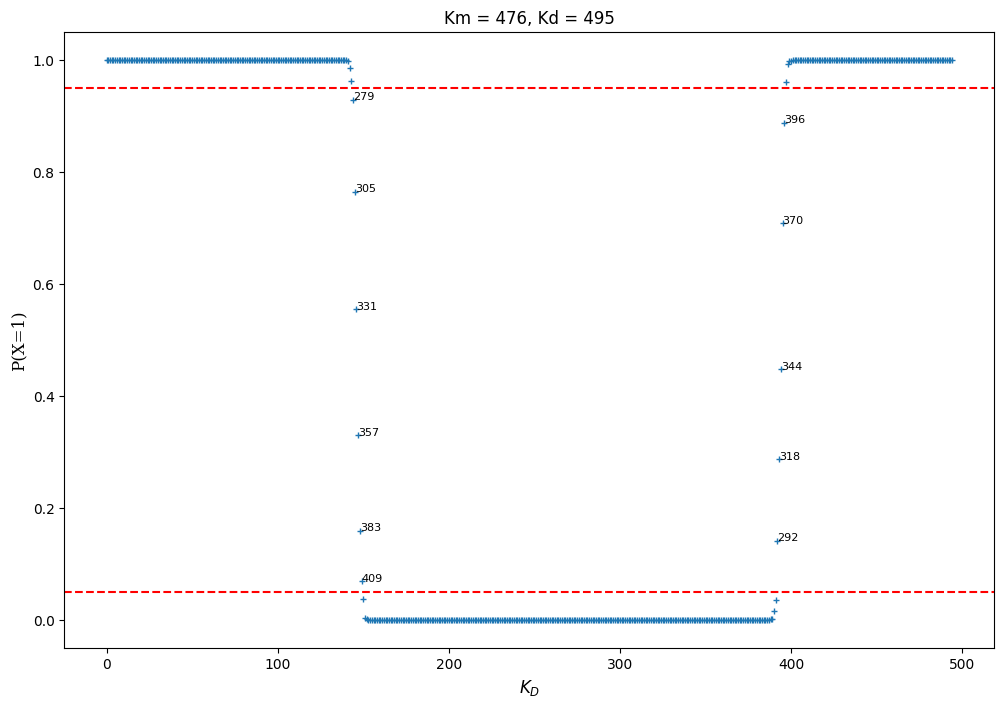

Nn of contributors: 11
Distances between contributors : [ 13  13  13  13  13  13  13  13  13  13 365]


In [4]:
# reorder inside Tq period, compute the p-value
# ---------------------------------------------
j = [(i * KM) % KD for i in range(KD)]
# reordered index
somme = np.sum(img, 0)
# sum per period
nsum = somme / len(img)
# normalized sum
z = zip(j, nsum)
# zip position and values
uz = list(zip(*sorted(z)))
# sort and unzip
period = uz[1]

# plot Tq period with indices and thresholds
# ---------------------------------------------
x = range(0, KD)
y = period
title = "Km = " + str(KM) + ", Kd = " + str(KD)
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(x, y, "+", markersize=4)
plt.xlabel("$K_D$", fontsize=12, family="serif")
plt.ylabel("P(X=1)", fontsize=12, family="serif")
plt.title(title)
plt.axhline(y=thr, color="r", linestyle="dashed")
plt.axhline(y=1 - thr, color="r", linestyle="dashed")
for ind in range(len(x)):
    if y[ind] > thr and y[ind] < (1 - thr):
        ax.text(x[ind], y[ind], j.index(ind), size=8)
plt.show()

# compute distances between contributors
# --------------------------------------

npuz = np.array(uz)
# j_jit: indice of points on edges, with overflow on the last indice to measure last distance
j_jit = np.where((npuz[1] < (1 - thr)) & (npuz[1] > thr))[0]
i_jit = []
for w in j_jit:
    i_jit.append(j.index(w))
i_jit.sort()
i_jit.append(i_jit[0] + KD)
ijit = np.array(i_jit)
d = ijit[1 : len(ijit)] - ijit[0 : (len(ijit) - 1)]

print("Nn of contributors: " + str(len(d)))
print("Distances between contributors : " + str(d))

## Bitmaps of Successive Periods

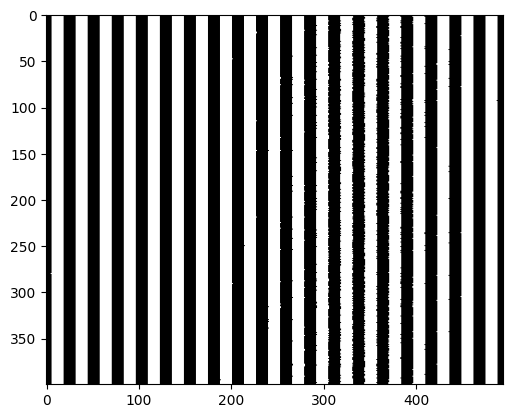

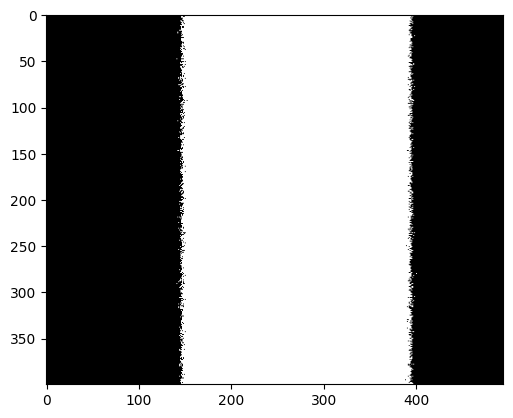

In [5]:
# plot bitmap of successive periods
# ---------------------------------
# image of successive Tq periods
TqBitmap = pd.DataFrame(img, index=range(len(img)), columns=j)
TqBitmap = TqBitmap.loc[::step]
# image of successive reordered periods
periodeBitmap = TqBitmap.sort_index(axis=1, ascending=True)
im1 = plt.imshow(TqBitmap, cmap="binary")
plt.show()
im1 = plt.imshow(periodeBitmap, cmap="binary")
plt.show()

## Online Tests

Nval: 8000
Mean: 247.26
Median: 247.0
Var: 1.01
aVar: 1.00
v from Pval: 1.79


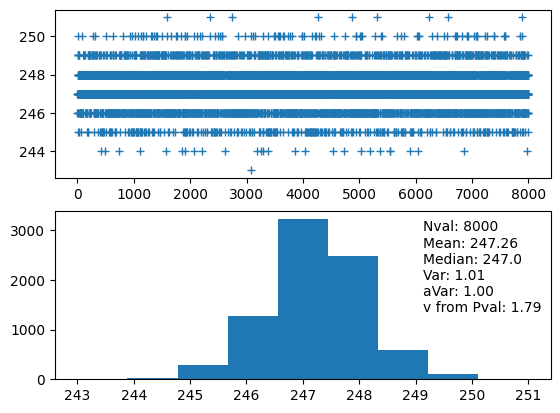

In [6]:
# online test: variance of counter of ones
# ----------------------------------------
# sum inside Tq period
nb_ones = np.sum(img, 1).astype(np.int_)
Mean = np.mean(nb_ones)
Median = np.median(nb_ones)
Var = np.var(nb_ones)
aVar = np.sum((nb_ones[1:Nsum] - nb_ones[: Nsum - 1]) ** 2) / (2 * (Nsum - 1))
# compute variance from P-values
Pval = somme / Nsum
indPval = np.where((Pval < (1 - thr)) & (Pval > thr))
jPval = Pval[indPval]
v = np.sum(jPval * (1 - jPval))
# plot successive values and histogram with statistics
plt.clf()
plt.subplot(2, 1, 1)
plt.plot(nb_ones, "+")
plt.subplot(2, 1, 2)
n_bins = nb_ones.max() - nb_ones.min() + 1
h = plt.hist(nb_ones, n_bins)
MyTxt = (
    "Nval: "
    + str(Nsum)
    + "\nMean: "
    + str("%0.2f" % Mean)
    + "\nMedian: "
    + str(Median)
    + "\nVar: "
    + str("%0.2f" % Var)
    + "\naVar: "
    + str("%0.2f" % aVar)
    + "\nv from Pval: "
    + str("%0.2f" % v)
)
print(MyTxt)
plt.figtext(0.7, 0.25, MyTxt)
plt.show()